In [3]:
import xlrd
import graphviz
import pydot
import pydotplus
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras import layers
import tensorflow as tf
import random
from sklearn.model_selection import KFold
from keras.callbacks import ReduceLROnPlateau

# Preparation

In [348]:
# Read data
data = pd.read_csv('Data_model_citation_counts.csv')
# Display Data
data

,times_cited,com1,com2,com3,com4,com5,com6,com7,com8,com9,...,avg_cocitation_degree,max_cocitation_degree,avg_cocitation_pagerank,max_cocitation_pagerank,avg_cocitation_closeness,max_cocitation_closeness,avg_cocitation_betweenness,max_cocitation_betweenness,avg_cocitation_eigenvector,max_cocitation_eigenvector
0,2,0,0,0,0,0,0,1,0,0,...,-0.812305,-0.844063,-0.700841,-0.678452,-1.645109,-0.828659,-0.366730,-0.349845,-0.752988,-0.828408
1,1,0,0,0,0,0,0,0,0,0,...,-0.812606,-0.844451,-0.490453,-0.569488,-2.726319,-3.024031,-0.366730,-0.349845,-0.753003,-0.828430
2,48,0,0,0,0,0,0,0,0,0,...,-0.812606,-0.844451,-0.717578,-0.697287,-2.726319,-3.024031,-0.366730,-0.349845,-0.753003,-0.828430
3,24,0,0,0,0,0,0,0,0,0,...,-0.628536,-0.532096,-0.535448,-0.430261,0.102117,0.249852,-0.351946,-0.328593,-0.619343,-0.568847
4,3,0,0,0,0,0,0,1,0,0,...,-0.686576,-0.710584,-0.570225,-0.553282,0.195121,0.120344,-0.356354,-0.340922,-0.685004,-0.745566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55019,33,0,0,0,0,0,0,0,0,0,...,2.051715,0.998639,5.059372,2.553292,0.923501,0.681408,10.533310,4.579372,0.638905,0.146249
55020,64,0,0,0,0,0,0,0,0,0,...,1.228599,0.468993,1.592733,0.602681,0.824773,0.581175,2.374633,0.889854,0.476812,0.032744
55021,32,0,0,0,1,0,0,0,0,0,...,-0.362556,-0.302388,-0.286997,-0.264262,0.446099,0.367708,-0.179878,-0.181007,-0.416045,-0.360568
55022,10,0,0,0,0,0,1,0,0,0,...,-0.405571,-0.320625,-0.540804,-0.498352,-1.074596,0.329756,-0.346609,-0.331647,-0.447493,-0.400565


In [349]:
data = np.array(data)

In [302]:
# 10-fold cross-validation
# Set division
kf = 10   # 10-fold
p = 78    # p-dimension
KF = KFold(n_splits = kf, shuffle = True, random_state = 7)

# Determine the number of layers and neurons

First, build a neural network model with only one hidden layer and set the initial number of neurons from 10 to 190 (increase 20 for each time). For each initial number, we train the model via the 10-fold cross-validation (CV). Further, the mean absolute error (MAE) of each validation set is reported and the average of the MAE is named the 10-fold CV MAE. The number of neurons corresponding to the minimum MAE is selected as the optimal number in this hidden layer. Second, fix the number of neurons in the previous hidden layer and add a new hidden layer. The optimal number of neurons in the newly added layer is determined by repeating the first step. Third, add model layers up to 4. 

## One hidden layer

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 1 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(initial_num, activation = "relu", name = "layer1"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_first_layer.csv", sep = ",", index = False)

## Two hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 2 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(initial_num, activation = "relu", name = "layer2"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_second_layer.csv",sep = ",", index = False)

Epoch 1/200
1548/1548 [==============================] - 6s 4ms/step - loss: 9.3954 - mae: 9.3954
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5664 - mae: 8.5664
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.2015 - mae: 8.2015
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0403 - mae: 8.0403
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8779 - mae: 7.8779
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8086 - mae: 7.8086
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.7165 - mae: 7.7165
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6376 - mae: 7.6376
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4856 - mae: 7.4856
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4180 - mae: 7.4180
Epoch 11/200
1548/1

1548/1548 [==============================] - 6s 4ms/step - loss: 5.0751 - mae: 5.0751
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0544 - mae: 5.0544
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0655 - mae: 5.0655
Epoch 86/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0558 - mae: 5.0558
Epoch 87/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0355 - mae: 5.0355
Epoch 88/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0297 - mae: 5.0297
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0232 - mae: 5.0232
Epoch 90/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0166 - mae: 5.0166
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0234 - mae: 5.0234
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9928 - mae: 4.9928
Epoch 93/200
1548/1548 

Epoch 44/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5046 - mae: 5.5046
Epoch 45/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4947 - mae: 5.4947
Epoch 46/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4613 - mae: 5.4613
Epoch 47/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4364 - mae: 5.4364
Epoch 48/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4171 - mae: 5.4171
Epoch 49/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4169 - mae: 5.4169
Epoch 50/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3886 - mae: 5.3886
Epoch 51/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3903 - mae: 5.3903
Epoch 52/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3454 - mae: 5.3454
Epoch 53/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3449 - mae: 5.3449
Epoch 54/2

## Three hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 3 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(initial_num, activation = "relu", name = "layer3"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_third_layer.csv", sep = ",", index = False)

Epoch 1/200
1548/1548 [==============================] - 7s 4ms/step - loss: 9.8750 - mae: 9.8750
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.8073 - mae: 8.8073
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.4712 - mae: 8.4712
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.2773 - mae: 8.2773
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.1411 - mae: 8.1411
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0689 - mae: 8.0689
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.9311 - mae: 7.9311
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.1306 - mae: 8.1306
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.9467 - mae: 7.9467
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8554 - mae: 7.8554
Epoch 11/200
1548/1

1548/1548 [==============================] - 6s 4ms/step - loss: 5.0372 - mae: 5.0372
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0248 - mae: 5.0248
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0399 - mae: 5.0399
Epoch 86/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0252 - mae: 5.0252
Epoch 87/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9998 - mae: 4.9998
Epoch 88/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9925 - mae: 4.9925
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9916 - mae: 4.9916
Epoch 90/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9692 - mae: 4.9692
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9675 - mae: 4.9675
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.9472 - mae: 4.9472
Epoch 93/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 5.4648 - mae: 5.4648
Epoch 57/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4399 - mae: 5.4399
Epoch 58/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4322 - mae: 5.4322
Epoch 59/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4061 - mae: 5.4061
Epoch 60/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3992 - mae: 5.3992
Epoch 61/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3717 - mae: 5.3717
Epoch 62/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3570 - mae: 5.3570
Epoch 63/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3475 - mae: 5.3475
Epoch 64/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3376 - mae: 5.3376
Epoch 65/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3343 - mae: 5.3343
Epoch 66/200
1548/1548 

## Four hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 4 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(10, activation = "relu", name = "layer3"),
            layers.Dense(initial_num, activation = "relu", name = "layer4"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_forth_layer.csv", sep = ",", index = False)

Epoch 1/200
1548/1548 [==============================] - 7s 4ms/step - loss: 9.8203 - mae: 9.8203
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.9070 - mae: 8.9070
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6593 - mae: 8.6593
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.8133 - mae: 8.8133
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.3882 - mae: 8.3882
Epoch 6/200
1548/1548 [==============================] - 7s 4ms/step - loss: 8.3934 - mae: 8.3934
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.1555 - mae: 8.1555
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5788 - mae: 8.5788
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5246 - mae: 8.5246
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.4456 - mae: 8.4456

Epoch 00010: Reduc

1548/1548 [==============================] - 6s 4ms/step - loss: 5.2575 - mae: 5.2575
Epoch 165/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2540 - mae: 5.2540
Epoch 166/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2582 - mae: 5.2582
Epoch 167/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2543 - mae: 5.2543
Epoch 168/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2465 - mae: 5.2465
Epoch 169/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2520 - mae: 5.2520
Epoch 170/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2444 - mae: 5.2444
Epoch 171/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2470 - mae: 5.2470
Epoch 172/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2473 - mae: 5.2473
Epoch 173/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2417 - mae: 5.2417
Epoch 174/200


1548/1548 [==============================] - 7s 4ms/step - loss: 4.8562 - mae: 4.8562
Epoch 127/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8531 - mae: 4.8531
Epoch 128/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8543 - mae: 4.8543
Epoch 129/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8513 - mae: 4.8513
Epoch 130/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8485 - mae: 4.8485
Epoch 131/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8469 - mae: 4.8469
Epoch 132/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8428 - mae: 4.8428
Epoch 133/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8437 - mae: 4.8437
Epoch 134/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8426 - mae: 4.8426
Epoch 135/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8370 - mae: 4.8370
Epoch 136/200


1548/1548 [==============================] - 6s 4ms/step - loss: 5.3783 - mae: 5.3783

Epoch 00088: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1928 - mae: 5.1928
Epoch 90/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1230 - mae: 5.1230
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0935 - mae: 5.0935
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0671 - mae: 5.0671
Epoch 93/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0538 - mae: 5.0538
Epoch 94/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0322 - mae: 5.0322
Epoch 95/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0212 - mae: 5.0212
Epoch 96/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.0084 - mae: 5.0084
Epoch 97/200
1548/1548 [=================

1548/1548 [==============================] - 6s 4ms/step - loss: 5.9463 - mae: 5.9463
Epoch 51/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9070 - mae: 5.9070
Epoch 52/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.9103 - mae: 5.9103
Epoch 53/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8949 - mae: 5.8949
Epoch 54/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8979 - mae: 5.8979
Epoch 55/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8894 - mae: 5.8894
Epoch 56/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8885 - mae: 5.8885
Epoch 57/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8567 - mae: 5.8567
Epoch 58/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.7852 - mae: 5.7852
Epoch 59/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8387 - mae: 5.8387
Epoch 60/200
1548/1548 

1548/1548 [==============================] - 6s 4ms/step - loss: 8.2872 - mae: 8.2872
Epoch 11/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.4554 - mae: 8.4554
Epoch 12/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0967 - mae: 8.0967
Epoch 13/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6776 - mae: 8.6776
Epoch 14/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.9476 - mae: 8.9476
Epoch 15/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6458 - mae: 8.6458

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 16/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0604 - mae: 8.0604
Epoch 17/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.5999 - mae: 7.5999
Epoch 18/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4470 - mae: 7.4470
Epoch 19/200
1548/1548 [=================

1548/1548 [==============================] - 7s 4ms/step - loss: 5.4669 - mae: 5.4669
Epoch 172/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4667 - mae: 5.4667
Epoch 173/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4667 - mae: 5.4667
Epoch 174/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4666 - mae: 5.4666
Epoch 175/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4666 - mae: 5.4666
Epoch 176/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4665 - mae: 5.4665
Epoch 177/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4664 - mae: 5.4664
Epoch 178/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4663 - mae: 5.4663
Epoch 179/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4664 - mae: 5.4664
Epoch 180/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4662 - mae: 5.4662
Epoch 181/200


1548/1548 [==============================] - 6s 4ms/step - loss: 4.8110 - mae: 4.8110
Epoch 130/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8088 - mae: 4.8088
Epoch 131/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8044 - mae: 4.8044
Epoch 132/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8019 - mae: 4.8019
Epoch 133/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8017 - mae: 4.8017
Epoch 134/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7961 - mae: 4.7961
Epoch 135/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7917 - mae: 4.7917
Epoch 136/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7922 - mae: 4.7922
Epoch 137/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7913 - mae: 4.7913
Epoch 138/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7876 - mae: 4.7876
Epoch 139/200


1548/1548 [==============================] - 6s 4ms/step - loss: 5.5899 - mae: 5.5899
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5931 - mae: 5.5931
Epoch 93/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5876 - mae: 5.5876
Epoch 94/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5879 - mae: 5.5879
Epoch 95/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5824 - mae: 5.5824
Epoch 96/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5816 - mae: 5.5816
Epoch 97/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5818 - mae: 5.5818
Epoch 98/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5773 - mae: 5.5773
Epoch 99/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5749 - mae: 5.5749
Epoch 100/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.5729 - mae: 5.5729
Epoch 101/200
1548/154

1548/1548 [==============================] - 6s 4ms/step - loss: 5.9631 - mae: 5.9631
Epoch 45/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9211 - mae: 5.9211
Epoch 46/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8831 - mae: 5.8831
Epoch 47/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8331 - mae: 5.8331
Epoch 48/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8133 - mae: 5.8133
Epoch 49/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.7596 - mae: 5.7596
Epoch 50/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.8812 - mae: 5.8812
Epoch 51/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.7769 - mae: 5.7769
Epoch 52/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.7136 - mae: 5.7136
Epoch 53/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.6559 - mae: 5.6559
Epoch 54/200
1548/1548 

Epoch 125/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6174 - mae: 4.6174
Epoch 126/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6138 - mae: 4.6138
Epoch 127/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6121 - mae: 4.6121
Epoch 128/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6104 - mae: 4.6104
Epoch 129/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6088 - mae: 4.6088
Epoch 130/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6068 - mae: 4.6068
Epoch 131/200
1548/1548 [==============================] - 7s 4ms/step - loss: 4.6062 - mae: 4.6062
Epoch 132/200
1548/1548 [==============================] - 7s 4ms/step - loss: 4.6049 - mae: 4.6049
Epoch 133/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6041 - mae: 4.6041
Epoch 134/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6039 - mae: 4.6039


1548/1548 [==============================] - 6s 4ms/step - loss: 5.4482 - mae: 5.4482
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4428 - mae: 5.4428
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4418 - mae: 5.4418
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4483 - mae: 5.4483
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4276 - mae: 5.4276
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4315 - mae: 5.4315
Epoch 86/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.4350 - mae: 5.4350
Epoch 87/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4216 - mae: 5.4216
Epoch 88/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4252 - mae: 5.4252
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4218 - mae: 5.4218
Epoch 90/200
1548/1548 

1548/1548 [==============================] - 6s 4ms/step - loss: 6.0749 - mae: 6.0749
Epoch 41/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0792 - mae: 6.0792
Epoch 42/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0761 - mae: 6.0761
Epoch 43/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0230 - mae: 6.0230
Epoch 44/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9954 - mae: 5.9954
Epoch 45/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0042 - mae: 6.0042
Epoch 46/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9742 - mae: 5.9742
Epoch 47/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9642 - mae: 5.9642
Epoch 48/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9330 - mae: 5.9330
Epoch 49/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9225 - mae: 5.9225
Epoch 50/200
1548/1548 

1548/1548 [==============================] - 6s 4ms/step - loss: 12.4405 - mae: 12.4405
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4407 - mae: 12.4407
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4397 - mae: 12.4397
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4410 - mae: 12.4410
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4398 - mae: 12.4398
Epoch 7/200
1548/1548 [==============================] - 7s 4ms/step - loss: 12.4404 - mae: 12.4404

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4366 - mae: 12.4366
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4360 - mae: 12.4360
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4359 - mae: 12.4359
Epoch 11/200
1548/1548 [======

1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355
Epoch 133/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355

Epoch 00133: ReduceLROnPlateau reducing learning rate to 1.0005271035279195e-43.
Epoch 134/200
1548/1548 [==============================] - 7s 4ms/step - loss: 12.4355 - mae: 12.4355
Epoch 135/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355
Epoch 136/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355

Epoch 00136: ReduceLROnPlateau reducing learning rate to 9.949219096706202e-45.
Epoch 137/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355
Epoch 138/200
1548/1548 [==============================] - 6s 4ms/step - loss: 12.4355 - mae: 12.4355
Epoch 139/200
1548/1548 [==============================] - 7s 4ms/step - loss: 12.4355 - mae: 12.4355

Epoch 00139: ReduceLROnPlateau red

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 7s 4ms/step - loss: 5.0880 - mae: 5.0880
Epoch 94/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0627 - mae: 5.0627
Epoch 95/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0694 - mae: 5.0694
Epoch 96/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0284 - mae: 5.0284
Epoch 97/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.0496 - mae: 5.0496
Epoch 98/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.0597 - mae: 5.0597
Epoch 99/200
1548/1548 [==============================] - 7s 4ms/step - loss: 5.0103 - mae: 5.0103
Epoch 100/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0149 - mae: 5.0149
Epoch 101/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0184 - mae: 5.0184
Epoch 102/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0129 - mae: 5.0129

Epoch 00102: Reduce

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.6448 - mae: 4.6448
Epoch 166/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6442 - mae: 4.6442
Epoch 167/200
1548/1548 [==============================] - 7s 4ms/step - loss: 4.6434 - mae: 4.6434
Epoch 168/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6432 - mae: 4.6432
Epoch 169/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6435 - mae: 4.6435
Epoch 170/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6423 - mae: 4.6423
Epoch 171/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6422 - mae: 4.6422
Epoch 172/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6419 - mae: 4.6419
Epoch 173/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6418 - mae: 4.6418
Epoch 174/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6413 - mae: 4.6413
Epoch 175/200


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 6.7351 - mae: 6.7351
Epoch 39/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.7964 - mae: 6.7964
Epoch 40/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.6585 - mae: 6.6585
Epoch 41/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.6295 - mae: 6.6295
Epoch 42/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.6820 - mae: 6.6820
Epoch 43/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.7223 - mae: 6.7223
Epoch 44/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.5380 - mae: 6.5380
Epoch 45/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.5593 - mae: 6.5593
Epoch 46/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.5358 - mae: 6.5358
Epoch 47/200
1548/1548 [==============================] - 7s 4ms/step - loss: 6.4285 - mae: 6.4285
Epoch 48/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 6.1387 - mae: 6.1387
Epoch 32/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0877 - mae: 6.0877
Epoch 33/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0785 - mae: 6.0785
Epoch 34/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0357 - mae: 6.0357
Epoch 35/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.0325 - mae: 6.0325
Epoch 36/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9897 - mae: 5.9897
Epoch 37/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9609 - mae: 5.9609
Epoch 38/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9205 - mae: 5.9205
Epoch 39/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9193 - mae: 5.9193
Epoch 40/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9002 - mae: 5.9002
Epoch 41/200
1548/1548 

1548/1548 [==============================] - 6s 4ms/step - loss: 4.4187 - mae: 4.4187
Epoch 195/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.4186 - mae: 4.4186
Epoch 196/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.4179 - mae: 4.4179
Epoch 197/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.4170 - mae: 4.4170
Epoch 198/200
1548/1548 [==============================] - 7s 4ms/step - loss: 4.4100 - mae: 4.4100
Epoch 199/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.4155 - mae: 4.4155
Epoch 200/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.4098 - mae: 4.4098
Epoch 1/200
1548/1548 [==============================] - 7s 4ms/step - loss: 9.6832 - mae: 9.6832
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6247 - mae: 8.6247
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.2034 - mae: 8.2034
Epoch 4/200
1548/154

1548/1548 [==============================] - 6s 4ms/step - loss: 5.1313 - mae: 5.1313
Epoch 77/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1412 - mae: 5.1412
Epoch 78/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1207 - mae: 5.1207
Epoch 79/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1363 - mae: 5.1363
Epoch 80/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1050 - mae: 5.1050
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0866 - mae: 5.0866
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0842 - mae: 5.0842
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0789 - mae: 5.0789
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0631 - mae: 5.0631
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0649 - mae: 5.0649
Epoch 86/200
1548/1548 

## The 10-fold CV MAE of the neural network model

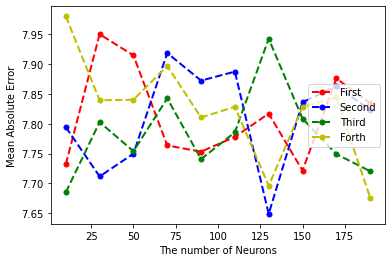

In [243]:
MAE_first = pd.read_csv("MAE_first_layer.csv")
MAE_first_result = pd.DataFrame(np.mat(np.array(MAE_first).reshape(10,10)))
MAE_second = pd.read_csv("MAE_second_layer.csv")
MAE_second_result = pd.DataFrame(np.mat(np.array(MAE_second).reshape(10,10)))
MAE_third = pd.read_csv("MAE_third_layer.csv")
MAE_third_result = pd.DataFrame(np.mat(np.array(MAE_third).reshape(10,10)))
MAE_forth = pd.read_csv("MAE_forth_layer.csv")
MAE_forth_result = pd.DataFrame(np.mat(np.array(MAE_forth).reshape(10,10)))
plt.plot(range(10,210,20), MAE_first_result.mean(),  c = 'r', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'First')
plt.plot(range(10,210,20), MAE_second_result.mean(), c = 'b', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Second')
plt.plot(range(10,210,20), MAE_third_result.mean(),  c = 'g', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Third')
plt.plot(range(10,210,20), MAE_forth_result.mean(),  c = 'y', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Forth')
plt.legend(loc='center right') # Legend
plt.xlabel('The number of Neurons', fontsize = 10)
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.show()

# Final Model

The two hidden layers have 150 and 130 neurons respectively

In [244]:
# Construct neural network model
kf = 10
p = 78
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model.csv", sep = ",", index = False)

Epoch 1/200
1548/1548 [==============================] - 6s 4ms/step - loss: 9.6199 - mae: 9.6199
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6091 - mae: 8.6091
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.3322 - mae: 8.3322
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.1234 - mae: 8.1234
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0133 - mae: 8.0133
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8810 - mae: 7.8810
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8040 - mae: 7.8040
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6959 - mae: 7.6959
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6139 - mae: 7.6139
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.5654 - mae: 7.5654
Epoch 11/200
1548/1

1548/1548 [==============================] - 6s 4ms/step - loss: 5.0948 - mae: 5.0948
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0980 - mae: 5.0980
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0831 - mae: 5.0831
Epoch 86/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0745 - mae: 5.0745
Epoch 87/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0642 - mae: 5.0642
Epoch 88/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0627 - mae: 5.0627
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0362 - mae: 5.0362
Epoch 90/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0297 - mae: 5.0297
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0183 - mae: 5.0183
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0121 - mae: 5.0121
Epoch 93/200
1548/1548 

Epoch 45/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3820 - mae: 5.3820
Epoch 46/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3769 - mae: 5.3769
Epoch 47/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3560 - mae: 5.3560
Epoch 48/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3307 - mae: 5.3307
Epoch 49/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3146 - mae: 5.3146
Epoch 50/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3003 - mae: 5.3003
Epoch 51/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2889 - mae: 5.2889
Epoch 52/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2533 - mae: 5.2533
Epoch 53/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2441 - mae: 5.2441
Epoch 54/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2387 - mae: 5.2387
Epoch 55/2

1548/1548 [==============================] - 6s 4ms/step - loss: 7.7498 - mae: 7.7498
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6713 - mae: 7.6713
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6471 - mae: 7.6471
Epoch 11/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4673 - mae: 7.4673
Epoch 12/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.5639 - mae: 7.5639
Epoch 13/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4374 - mae: 7.4374
Epoch 14/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.4793 - mae: 7.4793
Epoch 15/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3805 - mae: 7.3805
Epoch 16/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.2566 - mae: 7.2566
Epoch 17/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3181 - mae: 7.3181
Epoch 18/200
1548/1548 [

1548/1548 [==============================] - 6s 4ms/step - loss: 5.1186 - mae: 5.1186
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1173 - mae: 5.1173
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1084 - mae: 5.1084
Epoch 93/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1130 - mae: 5.1130
Epoch 94/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0918 - mae: 5.0918
Epoch 95/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0999 - mae: 5.0999
Epoch 96/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0657 - mae: 5.0657
Epoch 97/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0781 - mae: 5.0781
Epoch 98/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0739 - mae: 5.0739
Epoch 99/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0736 - mae: 5.0736

Epoch 00099: ReduceLRO

1548/1548 [==============================] - 6s 4ms/step - loss: 6.1667 - mae: 6.1667
Epoch 53/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.1732 - mae: 6.1732

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 54/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.7061 - mae: 5.7061
Epoch 55/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.4873 - mae: 5.4873
Epoch 56/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3840 - mae: 5.3840
Epoch 57/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.3164 - mae: 5.3164
Epoch 58/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2965 - mae: 5.2965
Epoch 59/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2396 - mae: 5.2396
Epoch 60/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2217 - mae: 5.2217
Epoch 61/200
1548/1548 [=================

1548/1548 [==============================] - 6s 4ms/step - loss: 7.4036 - mae: 7.4036
Epoch 14/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3481 - mae: 7.3481
Epoch 15/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.2235 - mae: 7.2235
Epoch 16/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1888 - mae: 7.1888
Epoch 17/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1483 - mae: 7.1483
Epoch 18/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1453 - mae: 7.1453
Epoch 19/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.0903 - mae: 7.0903
Epoch 20/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1930 - mae: 7.1930
Epoch 21/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.0801 - mae: 7.0801
Epoch 22/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8858 - mae: 6.8858
Epoch 23/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.8812 - mae: 4.8812
Epoch 113/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8852 - mae: 4.8852
Epoch 114/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8712 - mae: 4.8712
Epoch 115/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8521 - mae: 4.8521
Epoch 116/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8432 - mae: 4.8432
Epoch 117/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8596 - mae: 4.8596
Epoch 118/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8305 - mae: 4.8305
Epoch 119/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8354 - mae: 4.8354
Epoch 120/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8369 - mae: 4.8369
Epoch 121/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8101 - mae: 4.8101
Epoch 122/200


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 7.5569 - mae: 7.5569
Epoch 13/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3345 - mae: 7.3345
Epoch 14/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3138 - mae: 7.3138
Epoch 15/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3472 - mae: 7.3472
Epoch 16/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.3092 - mae: 7.3092
Epoch 17/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1204 - mae: 7.1204
Epoch 18/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1788 - mae: 7.1788
Epoch 19/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1433 - mae: 7.1433
Epoch 20/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8951 - mae: 6.8951
Epoch 21/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9667 - mae: 6.9667
Epoch 22/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 5.1787 - mae: 5.1787
Epoch 77/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1951 - mae: 5.1951
Epoch 78/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1494 - mae: 5.1494
Epoch 79/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1760 - mae: 5.1760
Epoch 80/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1514 - mae: 5.1514
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1448 - mae: 5.1448
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1449 - mae: 5.1449
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1198 - mae: 5.1198
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1194 - mae: 5.1194
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1078 - mae: 5.1078
Epoch 86/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 5.2738 - mae: 5.2738
Epoch 76/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2600 - mae: 5.2600
Epoch 77/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2715 - mae: 5.2715
Epoch 78/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2516 - mae: 5.2516
Epoch 79/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2381 - mae: 5.2381
Epoch 80/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2393 - mae: 5.2393
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2361 - mae: 5.2361
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2231 - mae: 5.2231
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2067 - mae: 5.2067
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2067 - mae: 5.2067
Epoch 85/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.8090 - mae: 4.8090

Epoch 00175: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 176/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8010 - mae: 4.8010
Epoch 177/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7968 - mae: 4.7968
Epoch 178/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7947 - mae: 4.7947
Epoch 179/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7929 - mae: 4.7929
Epoch 180/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7919 - mae: 4.7919
Epoch 181/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7904 - mae: 4.7904
Epoch 182/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7899 - mae: 4.7899
Epoch 183/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.7891 - mae: 4.7891
Epoch 184/200
1548/1548 [========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 5.1843 - mae: 5.1843
Epoch 75/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1793 - mae: 5.1793
Epoch 76/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1367 - mae: 5.1367
Epoch 77/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1482 - mae: 5.1482
Epoch 78/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1216 - mae: 5.1216
Epoch 79/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1125 - mae: 5.1125
Epoch 80/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1036 - mae: 5.1036
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1133 - mae: 5.1133
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0781 - mae: 5.0781
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.0818 - mae: 5.0818
Epoch 84/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.6204 - mae: 4.6204
Epoch 175/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6200 - mae: 4.6200
Epoch 176/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6201 - mae: 4.6201
Epoch 177/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6201 - mae: 4.6201
Epoch 178/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6200 - mae: 4.6200

Epoch 00178: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 179/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6183 - mae: 4.6183
Epoch 180/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6180 - mae: 4.6180
Epoch 181/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6178 - mae: 4.6178
Epoch 182/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6177 - mae: 4.6177
Epoch 183/200
1548/1548 [=========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 5.2136 - mae: 5.2136
Epoch 75/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2218 - mae: 5.2218
Epoch 76/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1949 - mae: 5.1949
Epoch 77/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.2057 - mae: 5.2057
Epoch 78/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1920 - mae: 5.1920
Epoch 79/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1661 - mae: 5.1661
Epoch 80/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1611 - mae: 5.1611
Epoch 81/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1671 - mae: 5.1671
Epoch 82/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1458 - mae: 5.1458
Epoch 83/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1412 - mae: 5.1412
Epoch 84/200
1548/1548 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.6657 - mae: 4.6657
Epoch 173/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6654 - mae: 4.6654
Epoch 174/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6660 - mae: 4.6660
Epoch 175/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6638 - mae: 4.6638
Epoch 176/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6618 - mae: 4.6618
Epoch 177/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6625 - mae: 4.6625
Epoch 178/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6608 - mae: 4.6608
Epoch 179/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6610 - mae: 4.6610
Epoch 180/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6580 - mae: 4.6580
Epoch 181/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.6588 - mae: 4.6588
Epoch 182/200


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1548/1548 [==============================] - 6s 4ms/step - loss: 4.8723 - mae: 4.8723
Epoch 124/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8549 - mae: 4.8549
Epoch 125/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8570 - mae: 4.8570
Epoch 126/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8444 - mae: 4.8444
Epoch 127/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8479 - mae: 4.8479
Epoch 128/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8360 - mae: 4.8360
Epoch 129/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8486 - mae: 4.8486
Epoch 130/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8403 - mae: 4.8403
Epoch 131/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8177 - mae: 4.8177
Epoch 132/200
1548/1548 [==============================] - 6s 4ms/step - loss: 4.8250 - mae: 4.8250
Epoch 133/200


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [245]:
#显示网络结构
model_one_layers.summary()

Model: "sequential_1787"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 77)                6006      
_________________________________________________________________
layer2 (Dense)               (None, 150)               11700     
_________________________________________________________________
layer3 (Dense)               (None, 130)               19630     
_________________________________________________________________
layer4 (Dense)               (None, 1)                 131       
Total params: 37,467
Trainable params: 37,467
Non-trainable params: 0
_________________________________________________________________


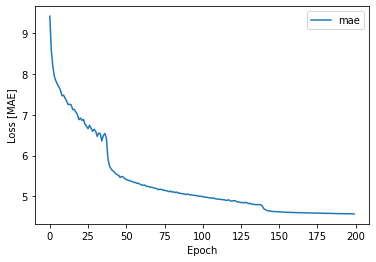

In [246]:
#绘制loss曲线
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss [MAE]')
plt.plot(hist['epoch'], hist['mae'],label='mae')
plt.legend()
plt.show()

# The Importance of Factors

The leave-one-feature-out method is adopted to measure the importance of factors \citep{li2022predicting}. First, we regard the model with all factors as the basic model. Second, we train the model by leaving one feature out and record the 10-fold CV MAE. Third, the absolute difference of the 10-fold CV MAE between the leave-one-feature-out model and the basic model is calculated. Finally, we normalize the absolute difference and transform it into a value between 0-100. The larger the value, the more important the factor is. 

In [ ]:
# Construct neural network model
kf = 10
MAE = np.zeros([kf*77])
i = 0
KF = KFold(n_splits = kf, shuffle=True, random_state=7)
for p in range(1,78):
    print(p)
    for train_index,test_index in KF.split(data):
        train_X = data[train_index, :]
        train_X = train_X[:, [_ for _ in range(1,78) if _ != p]]
        train_Y = data[train_index, 0]
        test_X = data[test_index, :]
        test_X = test_X[:, [_ for _ in range(1,78) if _ != p]]
        test_Y = data[test_index, 0]
        # Define Sequential model with 2 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(76, activation = "relu", name = "input", input_dim = 76),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel()-test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# 保存结果
MAE_leave_one_feature_out = pd.DataFrame(list(MAE))
MAE_leave_one_feature_out.to_csv("MAE_Leave_one_feature_out.csv", sep = ",", index = False)

1
Epoch 1/200
1548/1548 [==============================] - 6s 4ms/step - loss: 9.4904 - mae: 9.4904
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5817 - mae: 8.5817
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.3385 - mae: 8.3385
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0906 - mae: 8.0906
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0064 - mae: 8.0064
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8133 - mae: 7.8133
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8461 - mae: 7.8461
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6884 - mae: 7.6884
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6286 - mae: 7.6286
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6377 - mae: 7.6377
Epoch 11/200
1548

1548/1548 [==============================] - 6s 4ms/step - loss: 5.1845 - mae: 5.1845
Epoch 84/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1794 - mae: 5.1794
Epoch 85/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1864 - mae: 5.1864
Epoch 86/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1645 - mae: 5.1645
Epoch 87/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1455 - mae: 5.1455
Epoch 88/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1417 - mae: 5.1417
Epoch 89/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1490 - mae: 5.1490
Epoch 90/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1589 - mae: 5.1589
Epoch 91/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1357 - mae: 5.1357
Epoch 92/200
1548/1548 [==============================] - 6s 4ms/step - loss: 5.1337 - mae: 5.1337
Epoch 93/200
1548/1548 

# Comparison with other methods
## 9 commonly used methods
we select 9 commonly used methods to compare with our model, including XGBoost, gradient boosting, support vector regression, random forest, LightGBM, $k$-nearest neighbor regression, LASSO, elastic net and linear regression. For each method, we report the MAE on each validation set generated by 10-fold CV.

In [286]:
# Model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import time as time

### SVR

In [ ]:
score_SVR = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    svr = make_pipeline( SVR(kernel='linear')).fit(train_X, train_Y)
    # Prediction
    test_predictions = svr.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_SVR[i] = model_error.mean()
    i = i + 1

### LR

In [ ]:
score_LR = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    LR = make_pipeline(LinearRegression()).fit(train_X, train_Y)
    # Prediction
    test_predictions = LR.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LR[i] = model_error.mean()
    i = i + 1

### XGBoost

In [ ]:
score_Xgboost = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    model_xgb = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.8, gamma = 0,
                             learning_rate=0.1, max_depth=5,
                             n_estimators=500,min_child_weight=1,
                             reg_alpha=0, reg_lambda=1,
                             subsample=0.8,
                             random_state =42).fit(train_X, train_Y)
    # Prediction
    test_predictions = model_xgb.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_Xgboost[i] = model_error.mean()
    i = i + 1

### LASSO

In [346]:
score_LASSO = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    lasso = make_pipeline( Lasso(alpha =0.0005, random_state=1,max_iter=10000000, positive=True)).fit(train_X, train_Y)
    # Prediction
    test_predictions = lasso.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LASSO[i] = model_error.mean()
    i = i + 1

### Elastic Net

In [ ]:
score_ElasticNet = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    ENet = make_pipeline(ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3,max_iter=10000000)).fit(train_X, train_Y)
    # Prediction
    test_predictions = ENet.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_ElasticNet[i] = model_error.mean()
    i = i + 1

### Gradient Boosting

In [ ]:
score_GB = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    GBoost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02,
                                    max_depth=5, max_features=7,
                                    min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5).fit(train_X, train_Y)
    # Prediction
    test_predictions = GBoost.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_GB[i] = model_error.mean()
    i = i + 1

### LGBM

In [337]:
score_LGBM = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                               learning_rate=0.05, n_estimators=500).fit(train_X, train_Y)
    # Prediction
    test_predictions = model_lgb.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LGBM[i] = model_error.mean()
    i = i + 1

### Random Forest

In [336]:
score_RF = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    rf = RandomForestRegressor(n_estimators= 50, max_depth=25, min_samples_split=20,
                               min_samples_leaf=10,max_features='sqrt' ,oob_score=True, 
                               random_state=10).fit(train_X, train_Y)
    # Prediction
    test_predictions = rf.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_RF[i] = model_error.mean()
    i = i + 1

### KNN

In [334]:
score_KNN = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    knn = KNeighborsRegressor(n_neighbors=3).fit(train_X, train_Y)
    # Prediction
    test_predictions = knn.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_KNN[i] = model_error.mean()
    i = i + 1

In [347]:
# Save result
result = pd.DataFrame(list(zip(score_SVR, score_LASSO, score_ElasticNet, score_GB, score_Xgboost, score_LGBM, score_RF, score_KNN, score_LR)))
result.columns = ['score_SVR','score_LASSO','score_ElasticNet','score_GB','score_Xgboost','score_LGBM','score_RF','score_KNN','score_LR'] 
result.to_csv("Citation_count_pre_result.csv", sep = ",", index = False)
result

,score_SVR,score_LASSO,score_ElasticNet,score_GB,score_Xgboost,score_LGBM,score_RF,score_KNN,score_LR
0,8.060508,11.376153,11.611226,7.881905,7.827563,9.344578,8.839938,10.990551,11.626615
1,9.977483,12.349789,12.610718,9.784419,8.897829,10.450583,10.411239,12.060694,12.625850
2,9.022834,12.112551,12.186845,8.449269,8.518780,9.883509,9.607925,11.384094,12.194539
3,8.957908,12.269644,12.466566,8.433555,8.744953,9.851523,9.585174,11.186625,12.481218
4,9.466605,12.401840,12.751434,9.922363,8.944327,10.143121,10.589575,12.143342,12.769020
5,9.098736,12.761651,12.976705,8.521907,9.081119,10.309671,10.169187,11.157640,12.986860
6,8.133772,11.684322,11.869645,8.347290,9.061282,9.630114,9.444207,11.072883,11.884542
7,8.810542,12.100788,12.199119,9.215249,8.708297,9.846567,10.060862,11.742033,12.212592
8,7.997689,11.274594,11.247754,7.352334,7.709153,8.735782,8.634912,10.879438,11.259097
9,9.149973,12.411586,12.668067,8.559569,8.410199,10.340039,9.500519,12.103235,12.679618


## Two comparative models

To evaluate the performance of the network-related and topic-related factors, we create two comparative models. Refer to Model I as the basic model, which contains all the factors. Then, Model II contains only traditional factors but without network-related factors. Model III is similar to Model I, except that the topic-related factors used are extracted by the Latent Dirichlet Allocation (LDA) topic model.

### Model II

In [ ]:
a = [16,17,18,19,20,21,22,23,24,25,26,31,38,39,40,41,42,43,44,45,46,47]
kf = 10
p = 78
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, :]
    train_X = train_X[:, [_ for _ in range(1,78) if _ in a]]
    train_Y = data[train_index, 0]
    test_X = data[test_index, :]
    test_X = test_X[:, [_ for _ in range(1,78) if _ in a]]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(22, activation = "relu", name = "input", input_dim = 22),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model_traditional.csv", sep = ",", index = False)

Epoch 1/200
1548/1548 [==============================] - 6s 4ms/step - loss: 9.9418 - mae: 9.9418
Epoch 2/200
1548/1548 [==============================] - 6s 4ms/step - loss: 9.1496 - mae: 9.1496
Epoch 3/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.8488 - mae: 8.8488
Epoch 4/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.7972 - mae: 8.7972
Epoch 5/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.6730 - mae: 8.6730
Epoch 6/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5526 - mae: 8.5526
Epoch 7/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5719 - mae: 8.5719
Epoch 8/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.4750 - mae: 8.4750
Epoch 9/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.4019 - mae: 8.4019
Epoch 10/200
1548/1548 [==============================] - 6s 4ms/step - loss: 8.3332 - mae: 8.3332
Epoch 11/200
1548/1

1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 160/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 161/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053

Epoch 00161: ReduceLROnPlateau reducing learning rate to 9.99999874573554e-12.
Epoch 162/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 163/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 164/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053

Epoch 00164: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
Epoch 165/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 166/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8053 - mae: 6.8053
Epoch 167/200
1548/1548 [============================

Epoch 111/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9957 - mae: 6.9957
Epoch 112/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9956 - mae: 6.9956
Epoch 113/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9954 - mae: 6.9954
Epoch 114/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9950 - mae: 6.9950
Epoch 115/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9942 - mae: 6.9942
Epoch 116/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9937 - mae: 6.9937
Epoch 117/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9940 - mae: 6.9940
Epoch 118/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9925 - mae: 6.9925
Epoch 119/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9924 - mae: 6.9924
Epoch 120/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9920 - mae: 6.9920


1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 185/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 186/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728

Epoch 00186: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
Epoch 187/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 188/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 189/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728

Epoch 00189: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
Epoch 190/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 191/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9728 - mae: 6.9728
Epoch 192/200
1548/1548 [===========================

1548/1548 [==============================] - 6s 4ms/step - loss: 7.1726 - mae: 7.1726
Epoch 62/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1704 - mae: 7.1704

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 63/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1589 - mae: 7.1589
Epoch 64/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1583 - mae: 7.1583
Epoch 65/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1579 - mae: 7.1579
Epoch 66/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1577 - mae: 7.1577
Epoch 67/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1574 - mae: 7.1574
Epoch 68/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1573 - mae: 7.1573
Epoch 69/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1572 - mae: 7.1572
Epoch 70/200
1548/1548 [=================

1548/1548 [==============================] - 6s 4ms/step - loss: 7.8966 - mae: 7.8966
Epoch 25/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8720 - mae: 7.8720
Epoch 26/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8504 - mae: 7.8504
Epoch 27/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.9746 - mae: 7.9746
Epoch 28/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8011 - mae: 7.8011
Epoch 29/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8532 - mae: 7.8532
Epoch 30/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8736 - mae: 7.8736
Epoch 31/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.7537 - mae: 7.7537
Epoch 32/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.7540 - mae: 7.7540
Epoch 33/200
1548/1548 [==============================] - 6s 4ms/step - loss: 7.8306 - mae: 7.8306
Epoch 34/200
1548/1548 

1548/1548 [==============================] - 6s 4ms/step - loss: 6.9628 - mae: 6.9628
Epoch 107/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9296 - mae: 6.9296
Epoch 108/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9449 - mae: 6.9449
Epoch 109/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9349 - mae: 6.9349
Epoch 110/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9424 - mae: 6.9424

Epoch 00110: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 111/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8718 - mae: 6.8718
Epoch 112/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8546 - mae: 6.8546
Epoch 113/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8465 - mae: 6.8465
Epoch 114/200
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8429 - mae: 6.8429
Epoch 115/200
1548/1548 [========

### Model III

In [ ]:
# Read data
data = pd.read_csv('Data_model_citation_counts_new.csv')
data = np.array(data)

In [10]:
kf = 10
p = 61
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(60, activation = "relu", name = "input", input_dim = 60),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model_lda.csv", sep = ",", index = False)

Epoch 1/50
1548/1548 [==============================] - 6s 4ms/step - loss: 9.6757 - mae: 9.6757
Epoch 2/50
1548/1548 [==============================] - 6s 4ms/step - loss: 8.7589 - mae: 8.7589
Epoch 3/50
1548/1548 [==============================] - 6s 4ms/step - loss: 8.5209 - mae: 8.5209
Epoch 4/50
1548/1548 [==============================] - 6s 4ms/step - loss: 8.2421 - mae: 8.2421
Epoch 5/50
1548/1548 [==============================] - 6s 4ms/step - loss: 8.1665 - mae: 8.1665
Epoch 6/50
1548/1548 [==============================] - 6s 4ms/step - loss: 8.0415 - mae: 8.0415
Epoch 7/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.9932 - mae: 7.9932
Epoch 8/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.9273 - mae: 7.9273
Epoch 9/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6669 - mae: 7.6669
Epoch 10/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.6879 - mae: 7.6879
Epoch 11/50
1548/1548 [======

1548/1548 [==============================] - 6s 4ms/step - loss: 7.2484 - mae: 7.2484
Epoch 17/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.2636 - mae: 7.2636
Epoch 18/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.2111 - mae: 7.2111
Epoch 19/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.2848 - mae: 7.2848
Epoch 20/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.1309 - mae: 7.1309
Epoch 21/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.0512 - mae: 7.0512
Epoch 22/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9883 - mae: 6.9883
Epoch 23/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.0162 - mae: 7.0162
Epoch 24/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9321 - mae: 6.9321
Epoch 25/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.7877 - mae: 6.7877
Epoch 26/50
1548/1548 [=========

1548/1548 [==============================] - 6s 4ms/step - loss: 6.8845 - mae: 6.8845
Epoch 32/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.9536 - mae: 6.9536
Epoch 33/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.7774 - mae: 6.7774
Epoch 34/50
1548/1548 [==============================] - 6s 4ms/step - loss: 7.0128 - mae: 7.0128
Epoch 35/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.7884 - mae: 6.7884
Epoch 36/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.8204 - mae: 6.8204

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 37/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.3135 - mae: 6.3135
Epoch 38/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.1686 - mae: 6.1686
Epoch 39/50
1548/1548 [==============================] - 6s 4ms/step - loss: 6.1151 - mae: 6.1151
Epoch 40/50
1548/1548 [==========================

1548/1548 [==============================] - 6s 4ms/step - loss: 6.0075 - mae: 6.0075
Epoch 46/50
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9758 - mae: 5.9758
Epoch 47/50
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9603 - mae: 5.9603
Epoch 48/50
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9723 - mae: 5.9723
Epoch 49/50
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9441 - mae: 5.9441
Epoch 50/50
1548/1548 [==============================] - 6s 4ms/step - loss: 5.9091 - mae: 5.9091


In [30]:
MAE.to_csv("MAE_final_model_lda.csv", sep = ",", index = False)